In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from glob import glob
import pandas as pd
from subprocess import check_output
import os
from skimage.exposure import histogram
# GOOGLE COLAB: device = torch.device('cuda') 

Functions: 

In [2]:
def get_image_data(image_path): # into a tensor
    """
    Method to get image data as np.array specifying image id and type
    """
    #fname = get_filename(image_id, image_type)
        # fname = sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg
    img = cv2.imread(image_path)
        # cv2.imread(sample_train_cervix_shapes/Type{1, 2, 3}/???.jpg)
    #assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Plotting the histograms of the pixel values of each image (each channel separately) to see if standard normalization is okay:

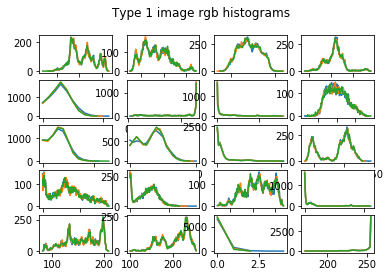

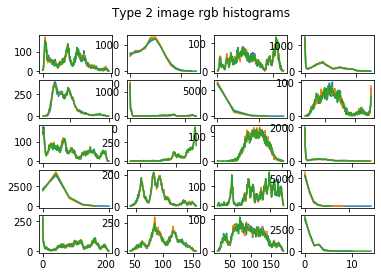

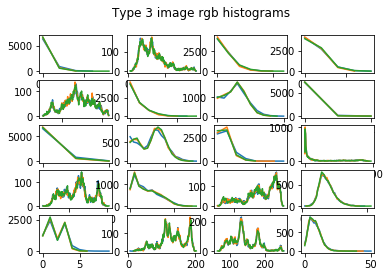

In [3]:
import glob
import os.path
from os import path
import torch
fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8),(ax9, ax10, ax11, ax12),(ax13, ax14, ax15, ax16),(ax17, ax18, ax19, ax20)) = plt.subplots(5,4)
fig.suptitle('Type 1 image rgb histograms')
i = 0
for file in list(glob.glob('sample_train_cervix_shapes/Type1/*')):
    i += 1
    img = plt.imread(file)
    hist_0, hist_centers_0 = histogram(img[0])
    hist_1, hist_centers_1 = histogram(img[1])
    hist_2, hist_centers_2 = histogram(img[2])
    
    globals()['ax%s' % i].plot(hist_centers_0,hist_0)
    globals()['ax%s' % i].plot(hist_centers_1,hist_1)
    globals()['ax%s' % i].plot(hist_centers_2,hist_2)
fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8),(ax9, ax10, ax11, ax12),(ax13, ax14, ax15, ax16),(ax17, ax18, ax19, ax20)) = plt.subplots(5,4)
fig.suptitle('Type 2 image rgb histograms')
i = 0
for file in list(glob.glob('sample_train_cervix_shapes/Type2/*')):
    i += 1
    img = plt.imread(file)
    hist_0, hist_centers_0 = histogram(img[0])
    hist_1, hist_centers_1 = histogram(img[1])
    hist_2, hist_centers_2 = histogram(img[2])
    
    globals()['ax%s' % i].plot(hist_centers_0,hist_0)
    globals()['ax%s' % i].plot(hist_centers_1,hist_1)
    globals()['ax%s' % i].plot(hist_centers_2,hist_2)
fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8),(ax9, ax10, ax11, ax12),(ax13, ax14, ax15, ax16),(ax17, ax18, ax19, ax20)) = plt.subplots(5,4)
fig.suptitle('Type 3 image rgb histograms')
i = 0
for file in list(glob.glob('sample_train_cervix_shapes/Type3/*')):
    i += 1
    img = plt.imread(file)
    hist_0, hist_centers_0 = histogram(img[0])
    hist_1, hist_centers_1 = histogram(img[1])
    hist_2, hist_centers_2 = histogram(img[2])
    
    globals()['ax%s' % i].plot(hist_centers_0,hist_0)
    globals()['ax%s' % i].plot(hist_centers_1,hist_1)
    globals()['ax%s' % i].plot(hist_centers_2,hist_2)

Edge-based segmentation (does not work for our images):

In [16]:
from skimage.feature import canny
from skimage.color import rgb2gray

img = plt.imread('sample_train_cervix_shapes/Type1/191.jpg')
img = rgb2gray(img) # you can only do edge detection on an image with one tensor, ie on grayscale image
    # thus, rgb2gray turns your 4128 x 3096 3 image to 4128 x 3096 x 1
    # if we don't do this we can use img[0], img[1], img[2] is the next line
edges = canny(img/255.)
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)
plt.imshow(fill_coins)

Region-based segmentation:

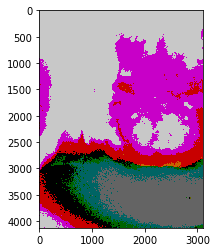

In [30]:
img = plt.imread('sample_train_cervix_shapes/Type1/191.jpg')
markers = np.zeros_like(img)
markers[img < 30] = 100
markers[img > 100] = 200
plt.imshow(markers)

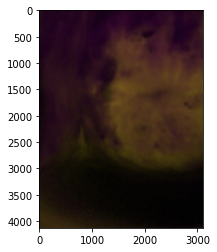

In [32]:
from skimage.filters import sobel
elevation_map = sobel(img)
plt.imshow(elevation_map)

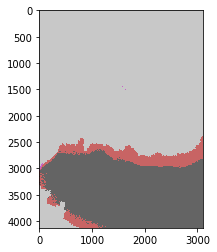

In [34]:
from skimage.segmentation import watershed
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation)

In [37]:
segmentation = ndi.binary_fill_holes(segmentation - 1)

In [38]:
labeled_coins, _ = ndi.label(segmentation)

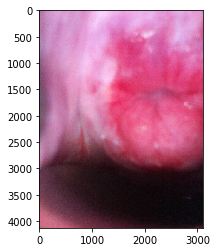

In [40]:
img = plt.imread('sample_train_cervix_shapes/Type1/191.jpg')
plt.imshow(img)

Label image regions (https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py)

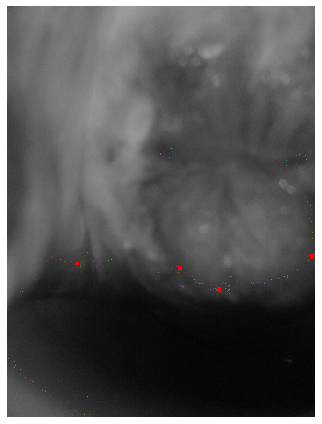

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = plt.imread('sample_train_cervix_shapes/Type1/191.jpg')
image = rgb2gray(img) 
# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh)
# remove artifacts connected to image border
cleared = clear_border(bw)
# label image regions
label_image = label(cleared)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

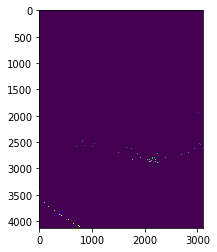

In [57]:
plt.imshow(label_image)